In [0]:
# Fill in your name using the format below and student ID number
your_name = "Lenz, Marc"
student_id = "1519018"

In [0]:
# Before submission, set this to True so that you can render and verify this notebook without training deep learning models.
# Any deep learning models will be trained from file instead.
stop_training = True

In [0]:
# Uncomment the following line to run in Google Colab
!pip install --quiet openml 

In [82]:
# Uncomment the following line to run in Google Colab
%tensorflow_version 2.x
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [0]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [84]:
from packaging import version
import sklearn
import tensorflow
sklearn_version = sklearn.__version__
tensorflow_version = tensorflow.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(tensorflow_version) < version.parse("2.1.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.1.".format(tensorflow_version))
else:
    print("Hi{}, Looks good. You may continue :)".format(your_name.split(",")[1]))

Hi Marc, Looks good. You may continue :)


# Assignment 3

### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. If you feel confident using PyTorch (and Skorch for the scikit-learn wrapper), that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you.

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
* Fill in the path to your assignment folder below
  * It's likely '/content/drive/My Drive/assignment-3-yourname'

In [0]:
base_dir = '/content/drive/My Drive/colab' # For Google Colab
#base_dir = './'

In [86]:
#Uncomment to link Colab notebook to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed things up training quite a bit. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 3rd cell on the top of this notebook to check that the GPU is found.

Note that Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are.
* When questions ask you to provide an explanation, it should be less than 500
characters long. Some questions have a higher limit. Always answer in full sentences.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. 
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters" yes: "More layers mean more parameters"). 
* Part of your grade depends on how well your model performs. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to run the verification script and check that all the results are included.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model.
* Be original. We will check for plagiarism between student submissions.

### Data
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build models that recognize the correct digit.

If you use Colab, uncomment the following to cache the dataset inside the VM. This will make reloading faster if you need to restart your notebook. After longer periods of inactivity, your VM may be recycled and the cache lost, in which case the dataset will be downloaded again. Also note that this dataset is about 1Gb large, and will take even more space in memory. You may need to switch to a high-RAM environment (Colab will ask you if you hit the limit).

In [0]:
# Use OpenML caching in Colab
# On your local machine, it will store data in a hidden folder '~/.openml'
import os
oml.config.cache_directory = os.path.expanduser('/content/cache')

In [0]:
# Download Streetview data. Takes a while (several minutes), and quite a bit of
# memory when it needs to download. After caching it loads faster.
SVHN = oml.datasets.get_dataset(41081)
X, y, _, _ = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

Reshape, sample and split the data

In [0]:
from tensorflow.keras.utils import to_categorical

Xr = X.reshape((len(X),32,32,3))
Xr = Xr / 255.
yr = to_categorical(y)

In [0]:
# DO NOT EDIT. DO NOT OVERWRITE THESE VARIABLES.
from sklearn.model_selection import train_test_split
# We do an 80-20 split for the training and test set, and then again a 80-20 split into training and validation data
X_train_all, X_test, y_train_all, y_test = train_test_split(Xr,yr, stratify=yr, train_size=0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all,y_train_all, stratify=y_train_all, train_size=0.8, random_state=1)
evaluation_split = X_train, X_val, y_train, y_val

Check the formatting - and what the data looks like

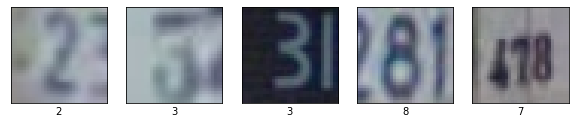

In [91]:
from random import randint

# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            axes[n].imshow(X[n], cmap='gray')
        else:
            axes[n].imshow(X[n])
        axes[n].set_xlabel((np.argmax(y[n])+1)%10) # Label is index+1
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

images = [randint(0,len(X_train)) for i in range(5)]
X_random = [X_train[i] for i in images]
y_random = [y_train[i] for i in images]
plot_images(X_random, y_random)

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [0]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

def load_model_from_file(base_dir, name, extension='.h5'):
    """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
    function following the Keras API. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    try:
        model = load_model(os.path.join(base_dir, name+extension))
    except OSError:
        shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
        return False
    return model

def save_model_to_file(model, base_dir, name, extension='.h5'):
    """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    model.save(os.path.join(base_dir, name+extension))

# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# DO NOT EDIT
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val),callbacks=[cb])
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        shout("Loading model from file", verbose)
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
        shout("Success!", verbose)
    # Report
    print(model.summary())
    lc = pd.DataFrame(learning_curves)
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    print(lc.apply(minMax))

Loading model from file
Success!
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_137 (Dense)            (None, 10)                30730     
_________________________________________________________________
dense_138 (Dense)            (None, 10)                110       
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  2.225635  0.168639  2.234462      0.190722
max  2.305942  0.190954  2.274436      0.190974


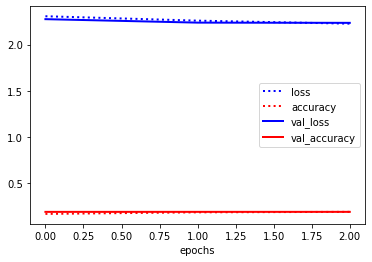

In [93]:
# Toy usage example
# Remove before submission
from tensorflow.keras import models
from tensorflow.keras import layers 

def build_toy_model():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# First build and store
run_evaluation("toy_example", build_toy_model, evaluation_split, base_dir, 
               train=True, epochs=3, batch_size=512)

Loading model from file
Success!
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_137 (Dense)            (None, 10)                30730     
_________________________________________________________________
dense_138 (Dense)            (None, 10)                110       
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  2.225635  0.168639  2.234462      0.190722
max  2.305942  0.190954  2.274436      0.190974


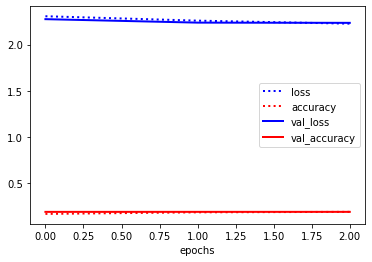

In [94]:
# Toy usage example
# Remove before submission
# With train=False: load from file and report the same results without rerunning
run_evaluation("toy_example", build_toy_model, evaluation_split, base_dir, 
               train=False)

## Part 1. Dense networks (10 points)

### Question 1.1: Baseline model (4 points)
- Build a dense network (with only dense layers) of at least 3 layers that is shaped like a pyramid: The first layer must have many nodes, and every subsequent layer must have increasingly fewer nodes, e.g. half as many. Implement a function 'build_model_1_1' that returns this model.
- You can explore different settings, but don't use any preprocessing or regularization yet. You should be able to achieve at least 70% accuracy, but more is of course better. Unless otherwise stated, you can use accuracy as the evaluation metric in all questions.
* Add a small description of your design choices (max. 500 characters) in 'answer_q_1_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- The name of the model should be 'model_1_1'. Evaluate it using the 'run_evaluation' function. For this question, you should not use more than 50 epochs.

Loading model from file
Success!
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_139 (Dense)            (None, 512)               1573376   
_________________________________________________________________
dense_140 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_141 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_142 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_143 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_144 (Dense)   

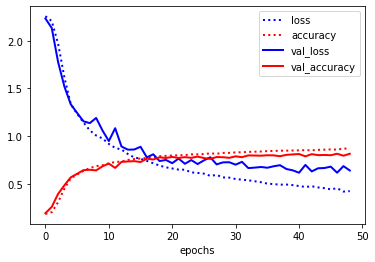

In [95]:
def build_model_1_1():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='Adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# First build and store
run_evaluation("build_model_1_1", build_model_1_1, evaluation_split, base_dir, 
               train=True, epochs=50, batch_size=512)

answer_q_1_1 = """
               Model structure: For the feature recoginiton, the dense layers with 
               ReLu activation, Softmax with 10 neurons as last layer can be interpreted as predicted class probabilities. 
              
               In combination with the class probabilities, categorical crossentropy is good choice for the loss function.

               + I implemented an early stopping criterion inside the evaluation fct to prevent overfitting. 

  
               """
print("Answer is {} characters long".format(len(answer_q_1_1)))

### Question 1.2: Preprocessing (2 points)
Rerun the model, but now preprocess the data first by converting the images to 
greyscale. You can use the helper function below. If you want to do additional 
preprocessing, you can do that here, too.
* Store the preprocessed data as a tuple `preprocessed_split`
* Rerun and re-evaluate your model using the preprocessed data.
  * For the remainder of the assignment, always use the preprocessed data
* Explain what you did and interpret the results in 'answer_q_1_2'. Is the model
  better, if so, why?

In [0]:
# Luminance-preserving RGB to greyscale conversion
def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)

Loading model from file
Success!
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)     

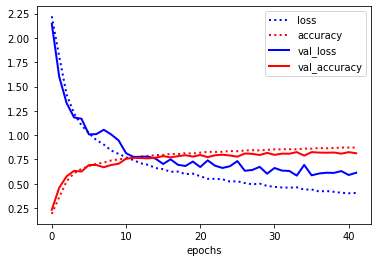

In [97]:
# Replace with the preprocessed data
X_train_p = rgb2gray(X_train)
X_val_p = rgb2gray(X_val)
#y_train_p = rgb2gray(y_train)
#y_val_p = rgb2gray(y_val)

preprocessed_split = X_train_p, X_val_p, y_train, y_val

# Adjusted model
def build_model_1_2():
  model = models.Sequential()
  model.add(layers.Reshape((int(3072/3),), input_shape=(32,32,1)))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  model.compile(optimizer='Adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

# Evaluate. Use a new name 'model_1_2' to not overwrite the previous trained model
run_evaluation("model_1_2", build_model_1_2, preprocessed_split, base_dir, 
               train=True, epochs=50, batch_size=512)

answer_q_1_2 = """
               The results are slightly better. Perhaps because for the given task color is not 
               important. Therefore, reducing it to a grayscale image simplifies the task without loosing 
               any quality of the data. 
               """
print("Answer is {} characters long".format(len(answer_q_1_2)))

### Question 1.3: Regularization and tuning (4 points)
* Regularize the model. You can explore (and combine) different techniques. What works best?
* Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
* Explain your findings and final design decisions. Retrain the model again on the preprocessed data and discuss the results.
* Return your model in function 'build_model_1_3' and write your answer in 'answer_q_1_3'

Loading model from file
Success!
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)  

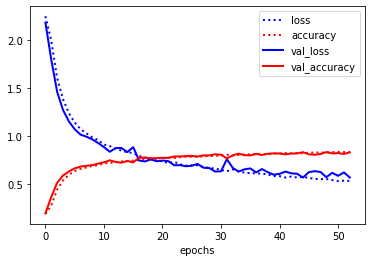

In [98]:
from keras import regularizers

do = 0.075
def build_model_1_3():
  model = models.Sequential()
  model.add(layers.Reshape((int(3072/3),), input_shape=(32,32,1)))
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(do))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(do))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(do))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(do))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  model.compile(optimizer='Adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  return model
run_evaluation("model_1_3", build_model_1_3, preprocessed_split, base_dir, 
               train=True, epochs=200, batch_size=512)
answer_q_1_3 = """
               By adding dropout the model generalizes better. The accuracy on the
               training dataset is lower than for the last two excercises but the validation
               accuracy is slightly higher. 
               """
print("Answer is {} characters long".format(len(answer_q_1_3)))

## Part 2. Convolutional neural networks (10 points)
### Question 2.1: Design a ConvNet (7 points)
- Build a sequential convolutional neural network. Try to achieve the best validation accuracy you can. You should be able to get at least 90% accuracy. You can use any depth, any combination of layers, and any kind of regularization and tuning. 
- Add a description of your design choices in 'answer_q_2_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- You are allowed **800** characters for this answer (but don’t ramble).
- The name of the model should be 'model_2_1'. Evaluate it using the 'run_evaluation' function and the preprocessed data.

Loading model from file
Success!
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_29 (Dense)     

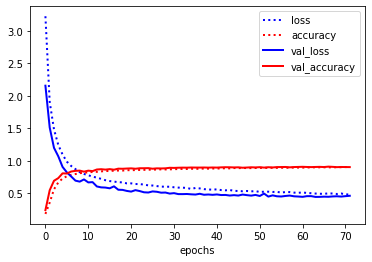

In [99]:
def build_model_2_1():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(10, activation='softmax'))
  model.compile(optimizer='Adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  return model
run_evaluation("model_2_1", build_model_2_1, preprocessed_split, base_dir, 
               train=True, epochs=100, batch_size=512)
answer_q_2_1 = """
               Structure:
               - 3 Convolutional layers to learn spatial features followed by Max-Pooling to 
                model with less parameters and better ability to generalize.
                - 2 Dense layers with ReLu to learn which spatial features are related to which class.  
                - 1 final dense layer with Softmax activation to obtain values which can be interpreted as class probabilities. 

                Loss fct: Again categorical crossentropy as for the same reasons as in Q1 
                
                -> Works a lot better than the dense layer network since the convolutional kernels 
                allow to detect spatial features in a much more efficient way. 
               """
print("Answer is {} characters long".format(len(answer_q_2_1)))

### Question 2.2: Data Augmentation (3 points)

- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, etc. What works well, and what does not?
- Evaluate the model from question 2.1 with the augmented data using the 'run_evaluation' function. Store the new trained model as 'model_2_2'.
- Add a description of your design choices in 'answer_q_2_2': explain what you did and also why. Also discuss the performance of the model.

Loading model from file
Success!
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_62 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_145 (Dense)   

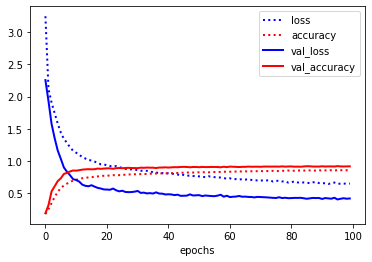

In [100]:
# Note that we build the same untrained model as in question 2.1 but store the 
# trained version as model_2_2. Change attributes as needed to run on augmented
# data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      #shear_range=0.2,
      #zoom_range=0.2,
      horizontal_flip=False,
      #fill_mode='nearest'
      )


train_datagen.fit(X_train_p)
t_gen = train_datagen.flow(X_train_p, y_train, batch_size=512)
steps = int(X_train.shape[0] / 512)

augmented_split = t_gen, X_val_p, y_val

#augmented_split = preprocessed_split
run_evaluation("model_2_2", build_model_2_1, augmented_split, base_dir, 
               train=True, epochs=100, generator=True,steps_per_epoch=steps)
answer_q_2_2 = """
               The result of the Data Augmentation is that the model generalizes better from the
               training data to the test data. It has a lower performance on the training dataset since
               the continued augmentation includes randomness and prevents the model from approximating 
               the training data too closely. This prevents the model from overfitting. 
               If the augmentation is too strong the performance of the model can even be generally worse.
               """
print("Answer is {} characters long".format(len(answer_q_2_2)))

## Part 3. Model interpretation (10 points)
### Question 3.1: Interpreting misclassifications (2 points)
Study which errors are still made by your last model (model_2_2) by evaluating it on the test data. You do not need to retrain the model.
* What is the accuracy of model_2_2 on the test data? Store this in 'test_accuracy_3_1'.
* Plot the confusion matrix in 'plot_confusion_matrix' and discuss which classes are often confused.
* Visualize the misclassifications in more depth by focusing on a single
class (e.g. the number '2') and analyse which kinds of mistakes are made for that class. For instance, are the errors related to the background, noisiness, etc.? Implement the visualization in 'plot_misclassifications'.
* Summarize your findings in 'answer_q_3_1'

accuracy score: 0.907946419579011


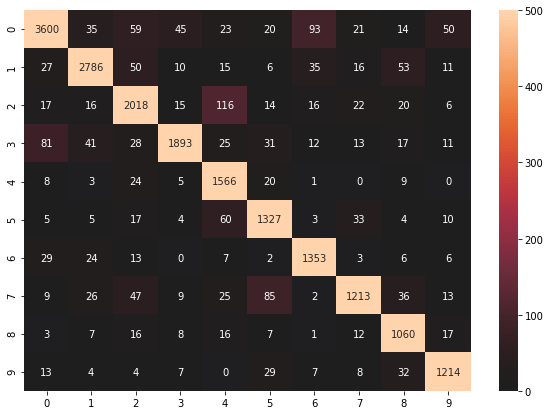

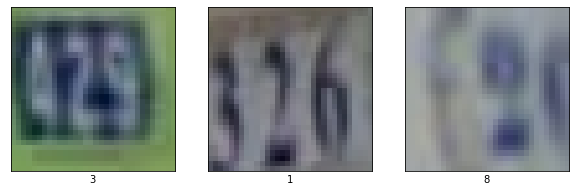

Answer is 450 characters long


In [101]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import random



#preprocessing
X_test_p = rgb2gray(X_test)
#load model
trained_model = load_model_from_file(base_dir, "model_2_1")
#get predictions and true labels
y_test_predict = trained_model.predict(X_test_p)
y_test_predict_binary = (y_test_predict == y_test_predict.max(axis=1)[:,None]).astype(int)
#compute accuracy score
acc_score = accuracy_score(y_test_predict_binary, y_test)
print("accuracy score: "+str(acc_score))
test_accuracy_3_1 = acc_score




def plot_confusion_matrix():
  cm = confusion_matrix(y_test_predict_binary.argmax(axis=1), y_test.argmax(axis=1))
  df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
  plt.figure(figsize = (10,7))
  sn.heatmap(cm, annot=True,fmt="d",vmin=0, vmax=500, center=10)

  pass

#plot_confusion_matrix()
def plot_misclassifications():
  #Get the false predictions for two
  true_equals_two = (y_test.argmax(axis=1) == 1)
  predict_is_not_two = (y_test_predict_binary.argmax(axis=1)!=1)
  false_prediction_indices = np.where(true_equals_two & predict_is_not_two)[0]

  sample_indices = random.sample(list(false_prediction_indices), 3)
  #images = [randint(0,len(false_prediction_indices)) for i in range(5)]

  X_sample_processed = [X_test_p[i] for i in sample_indices]
  X_sample_unprocessed = [X_test[i] for i in sample_indices]

  y_sample = trained_model.predict(np.asarray(X_sample_processed))
  plot_images(X_sample_unprocessed, y_sample)
  pass

plot_confusion_matrix()
plot_misclassifications()

answer_q_3_1 = """

               For the misclassification it turns out that a lot of the misinterpreted images are
               very blurry and even simply not interpretable, even for a human. 

               Also, numbers with similar features are often misclassified. 
               For instance the 0 is often misclassified as a 6, both are round. And the 2 is often misclassified as a 7,
               both share a diagonal. 
              
               """
print("Answer is {} characters long".format(len(answer_q_3_1)))

### Question 3.2: Visualizing activations (4 points)
* Implement a function `plot_activations()` that returns the most interesting activations (feature maps). Select the first example from the test set. Retrieve and visualize the activations of model 2_2 for that example (make sure you load that model in the function), for every filter for different convolutional layers (at different depths in the network).
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_2'. Is your model indeed learning something useful?

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


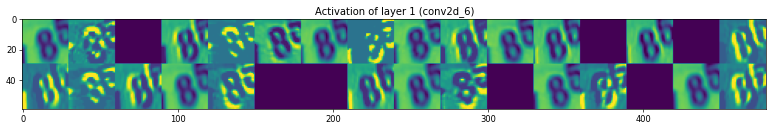

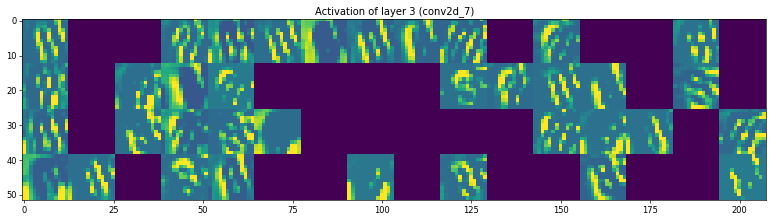

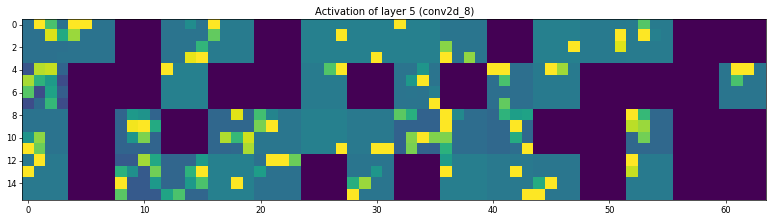

Answer is 750 characters long


In [102]:
plt.rcParams['figure.dpi'] = 60
images_per_row = 16
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in trained_model.layers]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=trained_model.input, outputs=layer_outputs)
#trained_model.summary()
layer_names = []
for layer in trained_model.layers:
    layer_names.append(layer.name)

s = 0
activations = activation_model.predict(np.asarray([X_test_p[s]]))
#plot_images(X_test[s], y_test[s])
#print(activations)
images_per_row = 16


def plot_activations(layer_index, activations):
    start = layer_index
    end = layer_index+1
    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names[start:end], activations[start:end]):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title("Activation of layer {} ({})".format(layer_index+1,layer_name))
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()
plot_activations(0, activations)
plot_activations(2, activations)
plot_activations(4, activations)
answer_q_3_2 = """
               Most of the feature maps show activations while others just
               stay blank. From those that show activations one can observe different patterns. 
               The digit in the example is an 8. Some of the feature maps show that parts of the outline of
               the digit are highlighted, some highlight the inner surface of the digit and others highlight only specific parts
               like the left or lower side of the digit. 

               The first convolutional layer is easier to interpret while the second and third layer show more abstract patterns. 
               In the activations of the first layer, the 8 is clearly recognizable while the second one shows more general patterns. 
               """
print("Answer is {} characters long".format(len(answer_q_3_2)))

### Question 3.3: Visualizing activations (4 points)
* Again, select the first example from the test set, and the trained model_2_2.
* Implement a function `plot_activation_map()` that builds and shows a class activation map for your last convolutional layer that highlights what the model is paying attention to when classifying the example.
* If possible, superimpossible the activation map over the image. If not, plot
them side by side. Implement a function 'plot_3_3' that returns the entire plot.

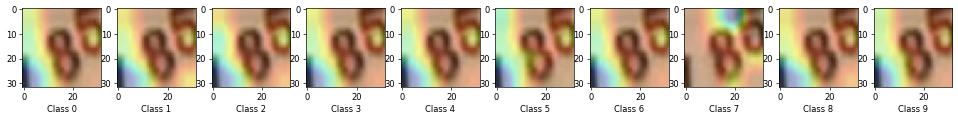

In [103]:
import cv2
from keras import backend as K

def plot_3_3():

  first_image = rgb2gray(X_test)[0]
  first_image = np.expand_dims(first_image, axis=0) 

  model = load_model_from_file(base_dir, "model_2_2")

  fig, axes = plt.subplots(1, 10,  figsize=(20, 10))

  for c in range(10): 
    class_eight_output = model.output[:, c]

    last_conv_layer = model.get_layer(index=4)
    grads = K.gradients(class_eight_output, last_conv_layer.output)[0]

    pooled_grads = K.mean(grads, axis=(0, 1,2))

    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([first_image])

    for i in range(64):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (32, 32))

    # image to heatmap shape for open cv 
    first_image_cv = X_test[0].reshape((32,32,3))

    # We convert the heatmap to RGB
    heatmap = np.uint8(255*heatmap)

    # We apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = heatmap / 255

    # 0.3 here is a heatmap intensity factor
    superimposed_img = 1 * first_image_cv + 0.3 * heatmap
    axes[c].imshow(superimposed_img)
    axes[c].set_xlabel('Class {}'.format((c)%10))
  
  plt.show(block=False)

plot_3_3()

## Part 4. Transfer learning (10 points)
### Question 4.1 Fast feature extraction with VGG16 (5 points)
- Import the VGG16 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_4_1` that adds a dense layer to the convolutional base, and freezes the convolutional base. Consider unfreezing the last few convolutional layers and evaluate whether that works better.
- Train the resulting model on the *original* (colored) training data
- Evaluate the resulting model using 'run_evaluate'. Discuss the observed performance in 'answer_q_4_1'.

Loading model from file
Success!
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                2570      
Total params: 14,848,586
Trainable params: 14,588,426
Non-trainable params: 260,160
___

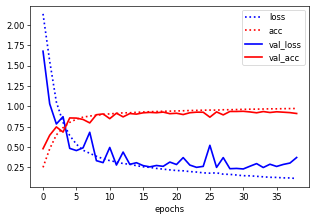

In [104]:
from tensorflow.keras.applications.vgg16 import VGG16
from keras import optimizers




def build_model_4_1():
  conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(32, 32, 3))

  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(10, activation='sigmoid'))

  set_trainable = False
  for layer in conv_base.layers:
      if layer.name in ['block5_conv1','block5_conv2','block5_conv3',
                        'block4_conv1','block4_conv2','block4_conv3',
                        'block3_conv1','block3_conv2','block3_conv3']:
          set_trainable = True
      if set_trainable:
          layer.trainable = True
      else:
          layer.trainable = False

  model.compile(optimizer= tf.keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True),
                  loss='categorical_crossentropy',
                  metrics=['acc'])
  return model
run_evaluation("model_4_1", build_model_4_1, evaluation_split, base_dir, 
               train=True, epochs=100, batch_size=512)
answer_q_4_1 = """
               Using the pretrained VGG16 lead to the best performing model so far. 
               The more layers unfrozen, the more prone the model was for overfitting which is exlainable by the higher number of trainable parameters.
                

               """
print("Answer is {} characters long".format(len(answer_q_4_1)))

### Question 4.2 Embeddings and pipelines (5 points)
- Generate embeddings of the original images by running them through the trained convolutional part of model_4_1 (without the dense layer) and returning the output. Embed the training and test data and store them to disk using the helper functions below. Implement a function `store_embeddings` that loads model_4_1 and stores all necessary embeddings to file. Make sure to run it once so that the embeddings are stored (and submitted).
- Implement a function 'generate_pipeline' that returns an scikit-learn pipeline. You can use any non-deep learning technique (eg. SVMs, RFs,...), and preprocessing technique. You can do model selection using the validation set. 
- Implement a function 'evaluate_pipeline' that evaluates a given pipeline on a given training and test set. 
- Implement a function 'evaluation_4_2' that evaluates your pipeline on the embedded training and test set (loaded from file) and returns the accuracy. 
- Describe what you did and what you observed. Report the obtained accuracy score. Can you beat your best model thus far?

In [105]:
import pickle
import gzip
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PowerTransformer, Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

vggmodel = load_model_from_file(base_dir, "model_4_1")
vgg16_m = vggmodel.get_layer("vgg16")

embmodel = models.Sequential()
embmodel.add(vgg16_m)
embmodel.add(layers.Flatten())

def store_embedding(X, name):
  X_embedded = embmodel.predict(X)  
  with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'wb') as file_pi:
    pickle.dump(X_embedded, file_pi)

def load_embedding(name):
  with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'rb') as file_pi:
    return pickle.load(file_pi)

def store_embeddings():
  """ Stores all necessary embeddings to file
  """
  store_embedding(X_train, "X_train_embeddings")
  store_embedding(X_val, "X_val_embeddings")
  pass


def generate_pipeline(clf=SVC(kernel='rbf',random_state=1), scaler=StandardScaler()): 
    pipe = Pipeline(steps=[('scaling', scaler), ("clff", clf)])
    return pipe


def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
  """ Evaluates the given pipeline, trained on the given embedded training set and 
      evaluated on the supplied embedded test set. Returns the accuracy score.
  """
  pipeline.fit(X_train, y_train)
  score = pipeline.score(X_test, y_test)
  return score


def evaluation_4_2(X_train, y_train, X_test, y_test):


  pipe = generate_pipeline()
  score = evaluate_pipeline(pipe, X_train, y_train, X_test, y_test)
  print("Accuracy: "+str(score))

  """ Runs 'evaluate_pipeline' with embedded versions of the input data 
  and returns the accuracy.

  model_dict = {  "log_regression" : LogisticRegression(random_state=1),
            "rbf_svm" : SVC(kernel='rbf',random_state=1),
            "random_forest" : RandomForestClassifier(random_state=1)}

  scaling_dict = {"standard scaling" : StandardScaler(),
            "normalizing": Normalizer()}
  model_scores = {}
  for model_key in model_dict.keys():
    scaling_scores = {}
    for scaling_key in scaling_dict.keys():
      model = model_dict[model_key]
      scaling = scaling_dict[scaling_key]
      pipe = generate_pipeline(model,scaling)
      #Compute scores here
      score = evaluate_pipeline(pipe, X_train, y_train, X_test, y_test)
      scaling_scores[scaling_key] = score
    model_scores[model_key] = scaling_scores

  print(model_scores)
  """
  pass

X_val_embedded = embmodel.predict(X_val)  
X_test_embedded = embmodel.predict(X_test) 
y_val_c = y_val.argmax(axis=1) 
y_test_c = y_test.argmax(axis=1) 

evaluation_4_2(X_val_embedded , y_val_c, X_test_embedded,y_test_c )
answer_q_4_2 = """
               I tested the pipeline on different classifiers and scalings. In the end 
               I decided to use and RBF Support Vector machine in combination with normalization of the data. 

               The accuracy is similar to the one of the neural network with dense layer at the end but slightly worse. 
               """
print("Pipeline:",generate_pipeline())
print("Answer is {} characters long".format(len(answer_q_4_2)))

Accuracy: 0.9295498036055998
Pipeline: Pipeline(memory=None,
         steps=[('scaling',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clff',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)
Answer is 337 characters long
